In [26]:
import pandas as pd
import numpy as np
import re
import os
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tqdm

In [27]:
# import random
# random.seed(42)

In [28]:
df = pd.read_csv('../data/hate/train.csv')
val_hate = pd.read_csv('../data/hate/val.csv')

In [29]:


def clean_text(x):
    x = re.sub(r'http\S+|www\S+|https\S+', '', str(x))
    x = re.sub(r'\s+', ' ', x)
    x = re.sub(r'[^a-zA-Z0-9\s]', '', x)
    x = re.sub(r'\d+', '', x)
    x = re.sub(r'[^\w\s]', '', x)
    x = re.sub(r'#', '', x)
    x = re.sub(r'\s+', ' ', x)
    x = x.strip()
    x = x.lower()
    return x

df['Sentence'] = df['Sentence'].apply(clean_text)

In [30]:

# Create Vocabulary
vocab = Counter(word for sentence in df['Sentence'] for word in sentence.split())
word2idx = {word: i for i, (word, _) in enumerate(vocab.items())}
idx2word = {i: word for word, i in word2idx.items()}
vocab_size = len(word2idx)
print("Vocabulary size:", vocab_size)

Vocabulary size: 12933


In [31]:


class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(Word2Vec, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        self.output_embeddings = nn.Embedding(vocab_size, embed_dim)
    
    def forward(self, target, context):
        target_emb = self.embeddings(target)  # (batch_size, embed_dim)
        context_emb = self.output_embeddings(context)  # (batch_size, embed_dim)
        scores = torch.sum(target_emb * context_emb, dim=1)  # Dot product similarity
        return scores

In [32]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [34]:

model = Word2Vec(vocab_size, 100).to(device)

In [35]:
import numpy as np

# Extract word embeddings
word_embeddings = model.embeddings.weight.data.cpu().numpy()  # Move to CPU if on GPU

# Save embeddings with word mappings
embedding_dict = {idx2word[i]: word_embeddings[i] for i in range(vocab_size)}

# Save as a NumPy file
np.save("models/word2vec/word_embeddings.npy", embedding_dict)

print("✅ Word embeddings saved successfully!")


✅ Word embeddings saved successfully!


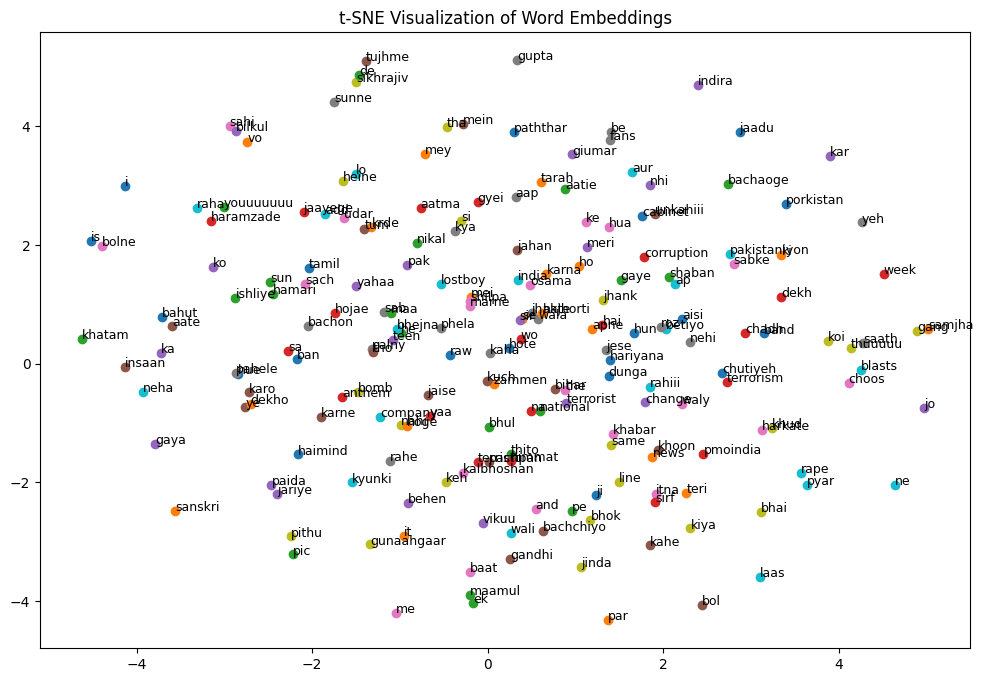

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load saved embeddings
embedding_dict = np.load("models/word2vec/word_embeddings.npy", allow_pickle=True).item()





# Convert to tensor
vocab_size = len(embedding_dict)
embedding_dim = len(next(iter(embedding_dict.values())))  # Get embedding size

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
word2idx = {word: idx for idx, word in enumerate(embedding_dict.keys())}

for word, idx in word2idx.items():
    embedding_matrix[idx] = embedding_dict[word]

embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)




# Select 200 most frequent words for visualization
top_words = list(embedding_dict.keys())[:200]
top_embeddings = np.array([embedding_dict[word] for word in top_words])


# Reduce dimensions to 2D
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(top_embeddings)

# Plot embeddings
plt.figure(figsize=(12, 8))
for i, word in enumerate(top_words):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1])
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=9)

plt.title("t-SNE Visualization of Word Embeddings")
plt.show()


In [37]:
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_words(target_word, top_n=5):
    if target_word not in embedding_dict:
        print("Word not in vocabulary!")
        return

    target_embedding = embedding_dict[target_word].reshape(1, -1)
    all_words = list(embedding_dict.keys())
    all_embeddings = np.array([embedding_dict[word] for word in all_words])

    # Compute cosine similarity
    similarities = cosine_similarity(target_embedding, all_embeddings)[0]
    top_indices = similarities.argsort()[-top_n-1:-1][::-1]

    # Display similar words
    print(f"Words similar to '{target_word}':")
    for idx in top_indices:
        print(f"{all_words[idx]} (Similarity: {similarities[idx]:.4f})")

# Example usage
find_similar_words("maa")


Words similar to 'maa':
itne (Similarity: 0.3407)
kadve (Similarity: 0.3391)
jao (Similarity: 0.3376)
incident (Similarity: 0.3334)
perpetrators (Similarity: 0.3246)


In [38]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader

# Load dataset
df = pd.read_csv("../data/hate/train.csv")
df['Sentence'] = df['Sentence'].apply(clean_text)

# Convert text to sequences of word indices
def text_to_sequence(text):
    return [word2idx[word] for word in text.split() if word in word2idx]

df["sequence"] = df["Sentence"].apply(text_to_sequence)

# Padding sequences to the same length
MAX_LEN = 100  # Choose max sentence length
def pad_sequence(seq, max_len=MAX_LEN):
    return seq[:max_len] + [0] * (max_len - len(seq))  # Pad with zeros if shorter

df["padded_seq"] = df["sequence"].apply(lambda x: pad_sequence(x))

# Convert labels to numerical valuesZ
label_mapping = {"hate": 0, "non-hate": 1,}  # Adjust if needed
df["label"] = df["Tag"].astype(int)

In [39]:
df


,Sentence,Tag,sequence,padded_seq,label
0,hariyana mey ek week mey teen bachchiyo ke saa...,1,"[0, 1, 2, 3, 1, 4, 5, 6, 7, 8, 9, 10, 11, 12, ...","[0, 1, 2, 3, 1, 4, 5, 6, 7, 8, 9, 10, 11, 12, ...",1
1,indira gandhi ko marne wala sikhrajiv gandhi k...,1,"[34, 35, 14, 36, 37, 38, 35, 14, 36, 39, 40, 4...","[34, 35, 14, 36, 37, 38, 35, 14, 36, 39, 40, 4...",1
2,ishliye corruption ke jariye sab ki khoon choo...,1,"[52, 53, 6, 54, 27, 41, 55, 56, 57, 58]","[52, 53, 6, 54, 27, 41, 55, 56, 57, 58, 0, 0, ...",1
3,pakistaniyon ko aisi news maamul sa ho gaya ha...,0,"[59, 14, 60, 61, 62, 63, 21, 64, 23, 65, 66, 6...","[59, 14, 60, 61, 62, 63, 21, 64, 23, 65, 66, 6...",0
4,apne national anthem ko change karo and yeh li...,1,"[71, 72, 73, 14, 74, 75, 76, 77, 78, 79, 75, 8...","[71, 72, 73, 14, 74, 75, 76, 77, 78, 79, 75, 8...",1
...,...,...,...,...,...
3655,sale kardi pakistan wali wo bhi unke talwe cha...,1,"[271, 12911, 602, 39, 153, 201, 301, 12912, 59...","[271, 12911, 602, 39, 153, 201, 301, 12912, 59...",1
3656,pti walayuchal rahay hain aik tweet prr dusri ...,0,"[11506, 12914, 2095, 533, 345, 565, 12915, 103...","[11506, 12914, 2095, 533, 345, 565, 12915, 103...",0
3657,jaa kay apny behan ky izaat bacha koi rape kaa...,0,"[1993, 1578, 1997, 1195, 1316, 12921, 1555, 88...","[1993, 1578, 1997, 1195, 1316, 12921, 1555, 88...",0
3658,oh godi told u nafirst day jab adi ki ek v sce...,1,"[3734, 10372, 5394, 796, 12922, 1320, 823, 741...","[3734, 10372, 5394, 796, 12922, 1320, 823, 741...",1


In [40]:
class HateSpeechDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Create dataset
dataset = HateSpeechDataset(df["padded_seq"].tolist(), df["label"].tolist())

# DataLoader
BATCH_SIZE = 64
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


In [ ]:
"""
THERE ARE TWO MODELS: .
1. BASE MODEL WITHOUT ANY DROPOUT OR LAYER NORMS
2. REFINED MODEL WITH DROPOUT AND LAYER NORMS - GIVES BETTER RESULTS
"""
# class FFNNClassifier(nn.Module):
#     def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
#         super(FFNNClassifier, self).__init__()
#         self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
#         self.fc1 = nn.Linear(embedding_dim, hidden_dim)
#         self.fc2 = nn.Linear(hidden_dim, num_classes)

#     def forward(self, x):
#         x = self.embedding(x)  # (batch_size, max_len, embed_dim)
#         x = torch.mean(x, dim=1)  # Average word embeddings (batch_size, embed_dim)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x  # No softmax, as we'll use CrossEntropyLoss

import torch.nn as nn
import torch.nn.functional as F

class FFNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, dropout=0.3):
        super(FFNNClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)

        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.dropout1 = nn.Dropout(dropout)

        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.norm2 = nn.LayerNorm(hidden_dim // 2)
        self.dropout2 = nn.Dropout(dropout)

        self.out = nn.Linear(hidden_dim // 2, num_classes)

    def forward(self, x):
        x = self.embedding(x)  # (batch_size, max_len, embed_dim)
        x = torch.mean(x, dim=1)  # (batch_size, embed_dim)

        x = F.relu(self.norm1(self.fc1(x)))
        x = self.dropout1(x)

        x = F.relu(self.norm2(self.fc2(x)))
        x = self.dropout2(x)

        x = self.out(x)
        return x


# Training Loop


In [42]:
# !export CUDA_LAUNCH_BLOCKING=1
import torch.optim as optim
embedding_dim = 100  # Same as the embedding dimension used in Word2Vec
# Set device
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

# Initialize model
model = FFNNClassifier(vocab_size, embedding_dim, hidden_dim=64, num_classes=2).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
from tqdm import tqdm

EPOCHS = 100
for epoch in range(EPOCHS):
    total_loss = 0
    model.train()
    
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for sequences, labels in loop:
        sequences, labels = sequences.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())  # Show loss in tqdm

    print(f"Epoch {epoch+1}/{EPOCHS}, Avg Loss: {total_loss / len(dataloader):.4f}")


Epoch 1/100:   0%|          | 0/58 [00:00<?, ?it/s, loss=0.654]

Epoch 1/100: 100%|██████████| 58/58 [00:00<00:00, 273.79it/s, loss=0.563]


Epoch 1/100, Avg Loss: 0.6673


Epoch 2/100: 100%|██████████| 58/58 [00:00<00:00, 296.97it/s, loss=0.644]


Epoch 2/100, Avg Loss: 0.6618


Epoch 3/100: 100%|██████████| 58/58 [00:00<00:00, 317.20it/s, loss=0.636]


Epoch 3/100, Avg Loss: 0.6610


Epoch 4/100: 100%|██████████| 58/58 [00:00<00:00, 311.66it/s, loss=0.751]


Epoch 4/100, Avg Loss: 0.6644


Epoch 5/100: 100%|██████████| 58/58 [00:00<00:00, 289.79it/s, loss=0.779]


Epoch 5/100, Avg Loss: 0.6630


Epoch 6/100: 100%|██████████| 58/58 [00:00<00:00, 291.24it/s, loss=0.676]


Epoch 6/100, Avg Loss: 0.6619


Epoch 7/100: 100%|██████████| 58/58 [00:00<00:00, 301.81it/s, loss=0.538]


Epoch 7/100, Avg Loss: 0.6604


Epoch 8/100: 100%|██████████| 58/58 [00:00<00:00, 303.56it/s, loss=0.635]


Epoch 8/100, Avg Loss: 0.6588


Epoch 9/100: 100%|██████████| 58/58 [00:00<00:00, 302.70it/s, loss=0.585]


Epoch 9/100, Avg Loss: 0.6598


Epoch 10/100: 100%|██████████| 58/58 [00:00<00:00, 287.41it/s, loss=0.69] 


Epoch 10/100, Avg Loss: 0.6600


Epoch 11/100: 100%|██████████| 58/58 [00:00<00:00, 285.76it/s, loss=0.721]


Epoch 11/100, Avg Loss: 0.6615


Epoch 12/100: 100%|██████████| 58/58 [00:00<00:00, 294.01it/s, loss=0.742]


Epoch 12/100, Avg Loss: 0.6614


Epoch 13/100: 100%|██████████| 58/58 [00:00<00:00, 289.12it/s, loss=0.639]


Epoch 13/100, Avg Loss: 0.6554


Epoch 14/100: 100%|██████████| 58/58 [00:00<00:00, 291.08it/s, loss=0.63] 


Epoch 14/100, Avg Loss: 0.6507


Epoch 15/100: 100%|██████████| 58/58 [00:00<00:00, 286.60it/s, loss=0.725]


Epoch 15/100, Avg Loss: 0.6369


Epoch 16/100: 100%|██████████| 58/58 [00:00<00:00, 307.33it/s, loss=0.69] 


Epoch 16/100, Avg Loss: 0.6224


Epoch 17/100: 100%|██████████| 58/58 [00:00<00:00, 297.13it/s, loss=0.422]


Epoch 17/100, Avg Loss: 0.5643


Epoch 18/100: 100%|██████████| 58/58 [00:00<00:00, 248.36it/s, loss=0.545]


Epoch 18/100, Avg Loss: 0.5428


Epoch 19/100: 100%|██████████| 58/58 [00:00<00:00, 249.14it/s, loss=0.418]


Epoch 19/100, Avg Loss: 0.4751


Epoch 20/100: 100%|██████████| 58/58 [00:00<00:00, 248.31it/s, loss=0.623]


Epoch 20/100, Avg Loss: 0.4454


Epoch 21/100: 100%|██████████| 58/58 [00:00<00:00, 248.40it/s, loss=0.608]


Epoch 21/100, Avg Loss: 0.4110


Epoch 22/100: 100%|██████████| 58/58 [00:00<00:00, 248.41it/s, loss=0.396]


Epoch 22/100, Avg Loss: 0.3927


Epoch 23/100: 100%|██████████| 58/58 [00:00<00:00, 293.68it/s, loss=0.858]


Epoch 23/100, Avg Loss: 0.3268


Epoch 24/100: 100%|██████████| 58/58 [00:00<00:00, 292.94it/s, loss=0.775]


Epoch 24/100, Avg Loss: 0.3383


Epoch 25/100: 100%|██████████| 58/58 [00:00<00:00, 241.19it/s, loss=0.461]


Epoch 25/100, Avg Loss: 0.2922


Epoch 26/100: 100%|██████████| 58/58 [00:00<00:00, 243.62it/s, loss=0.0427]


Epoch 26/100, Avg Loss: 0.2368


Epoch 27/100: 100%|██████████| 58/58 [00:00<00:00, 250.60it/s, loss=0.0764]


Epoch 27/100, Avg Loss: 0.2295


Epoch 28/100: 100%|██████████| 58/58 [00:00<00:00, 282.31it/s, loss=0.124] 


Epoch 28/100, Avg Loss: 0.2144


Epoch 29/100: 100%|██████████| 58/58 [00:00<00:00, 290.91it/s, loss=0.122]


Epoch 29/100, Avg Loss: 0.1984


Epoch 30/100: 100%|██████████| 58/58 [00:00<00:00, 283.01it/s, loss=0.597] 


Epoch 30/100, Avg Loss: 0.1976


Epoch 31/100: 100%|██████████| 58/58 [00:00<00:00, 286.23it/s, loss=0.0278]


Epoch 31/100, Avg Loss: 0.1358


Epoch 32/100: 100%|██████████| 58/58 [00:00<00:00, 298.72it/s, loss=0.0834]


Epoch 32/100, Avg Loss: 0.1416


Epoch 33/100: 100%|██████████| 58/58 [00:00<00:00, 331.66it/s, loss=0.11]  


Epoch 33/100, Avg Loss: 0.1905


Epoch 34/100: 100%|██████████| 58/58 [00:00<00:00, 328.96it/s, loss=0.0331]


Epoch 34/100, Avg Loss: 0.1399


Epoch 35/100: 100%|██████████| 58/58 [00:00<00:00, 325.89it/s, loss=0.164] 


Epoch 35/100, Avg Loss: 0.1386


Epoch 36/100: 100%|██████████| 58/58 [00:00<00:00, 332.03it/s, loss=0.39]  


Epoch 36/100, Avg Loss: 0.1349


Epoch 37/100: 100%|██████████| 58/58 [00:00<00:00, 288.38it/s, loss=0.302] 


Epoch 37/100, Avg Loss: 0.1452


Epoch 38/100: 100%|██████████| 58/58 [00:00<00:00, 289.13it/s, loss=0.0509]


Epoch 38/100, Avg Loss: 0.1082


Epoch 39/100: 100%|██████████| 58/58 [00:00<00:00, 288.19it/s, loss=0.0175]


Epoch 39/100, Avg Loss: 0.1019


Epoch 40/100: 100%|██████████| 58/58 [00:00<00:00, 281.57it/s, loss=0.594] 


Epoch 40/100, Avg Loss: 0.0806


Epoch 41/100: 100%|██████████| 58/58 [00:00<00:00, 282.02it/s, loss=0.127] 


Epoch 41/100, Avg Loss: 0.1096


Epoch 42/100: 100%|██████████| 58/58 [00:00<00:00, 284.41it/s, loss=0.274] 


Epoch 42/100, Avg Loss: 0.0945


Epoch 43/100: 100%|██████████| 58/58 [00:00<00:00, 273.73it/s, loss=0.0211]


Epoch 43/100, Avg Loss: 0.1035


Epoch 44/100: 100%|██████████| 58/58 [00:00<00:00, 286.32it/s, loss=0.00701]


Epoch 44/100, Avg Loss: 0.0766


Epoch 45/100: 100%|██████████| 58/58 [00:00<00:00, 284.02it/s, loss=0.00699]


Epoch 45/100, Avg Loss: 0.0786


Epoch 46/100: 100%|██████████| 58/58 [00:00<00:00, 275.45it/s, loss=0.00492]


Epoch 46/100, Avg Loss: 0.0824


Epoch 47/100: 100%|██████████| 58/58 [00:00<00:00, 284.00it/s, loss=0.00577]


Epoch 47/100, Avg Loss: 0.0610


Epoch 48/100: 100%|██████████| 58/58 [00:00<00:00, 278.40it/s, loss=0.0265] 


Epoch 48/100, Avg Loss: 0.0501


Epoch 49/100: 100%|██████████| 58/58 [00:00<00:00, 290.90it/s, loss=0.034]  


Epoch 49/100, Avg Loss: 0.0601


Epoch 50/100: 100%|██████████| 58/58 [00:00<00:00, 335.20it/s, loss=0.394]  


Epoch 50/100, Avg Loss: 0.0625


Epoch 51/100: 100%|██████████| 58/58 [00:00<00:00, 300.28it/s, loss=0.0279]


Epoch 51/100, Avg Loss: 0.0736


Epoch 52/100: 100%|██████████| 58/58 [00:00<00:00, 293.34it/s, loss=0.0143] 


Epoch 52/100, Avg Loss: 0.0551


Epoch 53/100: 100%|██████████| 58/58 [00:00<00:00, 291.54it/s, loss=0.0172] 


Epoch 53/100, Avg Loss: 0.0783


Epoch 54/100: 100%|██████████| 58/58 [00:00<00:00, 293.72it/s, loss=0.0104] 


Epoch 54/100, Avg Loss: 0.0474


Epoch 55/100: 100%|██████████| 58/58 [00:00<00:00, 281.94it/s, loss=0.00422]


Epoch 55/100, Avg Loss: 0.0492


Epoch 56/100: 100%|██████████| 58/58 [00:00<00:00, 287.81it/s, loss=0.0665] 


Epoch 56/100, Avg Loss: 0.0604


Epoch 57/100: 100%|██████████| 58/58 [00:00<00:00, 297.14it/s, loss=0.00782]


Epoch 57/100, Avg Loss: 0.0526


Epoch 58/100: 100%|██████████| 58/58 [00:00<00:00, 294.61it/s, loss=0.0156]


Epoch 58/100, Avg Loss: 0.0700


Epoch 59/100: 100%|██████████| 58/58 [00:00<00:00, 295.02it/s, loss=0.00656]


Epoch 59/100, Avg Loss: 0.0483


Epoch 60/100: 100%|██████████| 58/58 [00:00<00:00, 314.58it/s, loss=0.00475]


Epoch 60/100, Avg Loss: 0.0724


Epoch 61/100: 100%|██████████| 58/58 [00:00<00:00, 333.62it/s, loss=0.028]  


Epoch 61/100, Avg Loss: 0.0567


Epoch 62/100: 100%|██████████| 58/58 [00:00<00:00, 337.19it/s, loss=0.012]  


Epoch 62/100, Avg Loss: 0.0626


Epoch 63/100: 100%|██████████| 58/58 [00:00<00:00, 338.10it/s, loss=0.0371] 


Epoch 63/100, Avg Loss: 0.0442


Epoch 64/100: 100%|██████████| 58/58 [00:00<00:00, 339.86it/s, loss=0.0113]


Epoch 64/100, Avg Loss: 0.0835


Epoch 65/100: 100%|██████████| 58/58 [00:00<00:00, 337.02it/s, loss=0.0035]


Epoch 65/100, Avg Loss: 0.0538


Epoch 66/100: 100%|██████████| 58/58 [00:00<00:00, 340.01it/s, loss=0.0117] 


Epoch 66/100, Avg Loss: 0.0505


Epoch 67/100: 100%|██████████| 58/58 [00:00<00:00, 336.53it/s, loss=0.0264] 


Epoch 67/100, Avg Loss: 0.0441


Epoch 68/100: 100%|██████████| 58/58 [00:00<00:00, 339.05it/s, loss=0.142] 


Epoch 68/100, Avg Loss: 0.1067


Epoch 69/100: 100%|██████████| 58/58 [00:00<00:00, 336.66it/s, loss=0.00682]


Epoch 69/100, Avg Loss: 0.0442


Epoch 70/100: 100%|██████████| 58/58 [00:00<00:00, 334.99it/s, loss=0.0059] 


Epoch 70/100, Avg Loss: 0.0512


Epoch 71/100: 100%|██████████| 58/58 [00:00<00:00, 333.57it/s, loss=0.545]  


Epoch 71/100, Avg Loss: 0.0456


Epoch 72/100: 100%|██████████| 58/58 [00:00<00:00, 334.65it/s, loss=0.0276] 


Epoch 72/100, Avg Loss: 0.0407


Epoch 73/100: 100%|██████████| 58/58 [00:00<00:00, 313.52it/s, loss=0.00147]


Epoch 73/100, Avg Loss: 0.0277


Epoch 74/100: 100%|██████████| 58/58 [00:00<00:00, 294.83it/s, loss=0.0917] 


Epoch 74/100, Avg Loss: 0.0358


Epoch 75/100: 100%|██████████| 58/58 [00:00<00:00, 294.57it/s, loss=0.00708]


Epoch 75/100, Avg Loss: 0.0354


Epoch 76/100: 100%|██████████| 58/58 [00:00<00:00, 291.24it/s, loss=0.00412]


Epoch 76/100, Avg Loss: 0.0392


Epoch 77/100: 100%|██████████| 58/58 [00:00<00:00, 329.78it/s, loss=0.00374]


Epoch 77/100, Avg Loss: 0.0199


Epoch 78/100: 100%|██████████| 58/58 [00:00<00:00, 335.30it/s, loss=0.00114]


Epoch 78/100, Avg Loss: 0.0275


Epoch 79/100: 100%|██████████| 58/58 [00:00<00:00, 330.11it/s, loss=0.0171] 


Epoch 79/100, Avg Loss: 0.0345


Epoch 80/100: 100%|██████████| 58/58 [00:00<00:00, 331.17it/s, loss=0.0371] 


Epoch 80/100, Avg Loss: 0.0328


Epoch 81/100: 100%|██████████| 58/58 [00:00<00:00, 317.87it/s, loss=0.138]  


Epoch 81/100, Avg Loss: 0.0263


Epoch 82/100: 100%|██████████| 58/58 [00:00<00:00, 308.43it/s, loss=0.448]  


Epoch 82/100, Avg Loss: 0.0511


Epoch 83/100: 100%|██████████| 58/58 [00:00<00:00, 312.92it/s, loss=0.0956]


Epoch 83/100, Avg Loss: 0.1050


Epoch 84/100: 100%|██████████| 58/58 [00:00<00:00, 298.33it/s, loss=0.0074] 


Epoch 84/100, Avg Loss: 0.0231


Epoch 85/100: 100%|██████████| 58/58 [00:00<00:00, 300.25it/s, loss=0.0087] 


Epoch 85/100, Avg Loss: 0.0557


Epoch 86/100: 100%|██████████| 58/58 [00:00<00:00, 299.33it/s, loss=0.00193]


Epoch 86/100, Avg Loss: 0.0477


Epoch 87/100: 100%|██████████| 58/58 [00:00<00:00, 298.50it/s, loss=0.00471]


Epoch 87/100, Avg Loss: 0.0275


Epoch 88/100: 100%|██████████| 58/58 [00:00<00:00, 336.20it/s, loss=0.0038] 


Epoch 88/100, Avg Loss: 0.0188


Epoch 89/100: 100%|██████████| 58/58 [00:00<00:00, 337.09it/s, loss=0.00128]


Epoch 89/100, Avg Loss: 0.0185


Epoch 90/100: 100%|██████████| 58/58 [00:00<00:00, 336.59it/s, loss=0.155]   


Epoch 90/100, Avg Loss: 0.0199


Epoch 91/100: 100%|██████████| 58/58 [00:00<00:00, 244.14it/s, loss=0.003]  


Epoch 91/100, Avg Loss: 0.0362


Epoch 92/100: 100%|██████████| 58/58 [00:00<00:00, 218.31it/s, loss=0.012]  


Epoch 92/100, Avg Loss: 0.0260


Epoch 93/100: 100%|██████████| 58/58 [00:00<00:00, 236.04it/s, loss=0.079]  


Epoch 93/100, Avg Loss: 0.0435


Epoch 94/100: 100%|██████████| 58/58 [00:00<00:00, 291.43it/s, loss=0.0029] 


Epoch 94/100, Avg Loss: 0.0313


Epoch 95/100: 100%|██████████| 58/58 [00:00<00:00, 291.21it/s, loss=0.00409]


Epoch 95/100, Avg Loss: 0.0267


Epoch 96/100: 100%|██████████| 58/58 [00:00<00:00, 293.50it/s, loss=0.00157]


Epoch 96/100, Avg Loss: 0.0172


Epoch 97/100: 100%|██████████| 58/58 [00:00<00:00, 290.24it/s, loss=0.00275]


Epoch 97/100, Avg Loss: 0.0138


Epoch 98/100: 100%|██████████| 58/58 [00:00<00:00, 288.00it/s, loss=0.00167]


Epoch 98/100, Avg Loss: 0.0182


Epoch 99/100: 100%|██████████| 58/58 [00:00<00:00, 289.89it/s, loss=0.103]   


Epoch 99/100, Avg Loss: 0.0168


Epoch 100/100: 100%|██████████| 58/58 [00:00<00:00, 288.45it/s, loss=0.0702] 

Epoch 100/100, Avg Loss: 0.0407


In [ ]:
torch.save(model.state_dict(), "models/word2vec/hate/ffnn_classifier_73hatef1_100epoch_as1_cleantext_12kvocab.pth")

In [43]:
model.eval()

FFNNClassifier(
  (embedding): Embedding(12933, 100)
  (fc1): Linear(in_features=100, out_features=64, bias=True)
  (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=32, out_features=2, bias=True)
)

In [44]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(model, dataloader, device, label_names=["hate", "non-hate"]):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for sequences, labels in tqdm(dataloader, desc="Evaluating"):
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            predictions = torch.argmax(outputs, dim=1)

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Accuracy
    acc = accuracy_score(all_labels, all_preds)
    print(f"\n✅ Accuracy: {acc:.4f}")

    # Classification Report
    print("\n📄 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=label_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


In [45]:
# Clean the text
val_hate['Sentence'] = val_hate['Sentence'].apply(clean_text)

# Convert text to word index sequences
val_hate['sequence'] = val_hate['Sentence'].apply(text_to_sequence)
val_hate['padded_seq'] = val_hate['sequence'].apply(lambda x: pad_sequence(x))

# Convert label (assuming same label structure as train)
val_hate['label'] = val_hate['Tag'].astype(int)


In [46]:
# Create Dataset
val_dataset = HateSpeechDataset(val_hate["padded_seq"].tolist(), val_hate["label"].tolist())

# Create DataLoader
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 1015.51it/s]


✅ Accuracy: 0.6958

📄 Classification Report:
              precision    recall  f1-score   support

        hate       0.74      0.84      0.79       309
    non-hate       0.54      0.39      0.45       148

    accuracy                           0.70       457
   macro avg       0.64      0.62      0.62       457
weighted avg       0.68      0.70      0.68       457



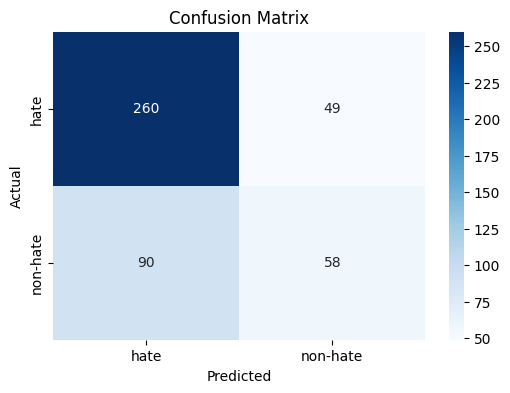

In [47]:
evaluate(model, val_loader, device)
